# 이미지 증강(Image Augmentation)을 사용하여 CNN 학습

> # Overfitting 대응책

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Tensorflow

In [2]:
import tensorflow

tensorflow.__version__

'2.5.0'

## [Optional] Image Augmentation Test

* rotation_range = 40 : 0도에서 40도 사이에서 임의의 각도록 회전
* width_shift_range = 0.2 : 20% 픽셀 내외로 좌우 이동
* height_shift_range = 0.2 : 20% 픽셀 내외로 상하 이동
* shear_range = 0.2 : 0.2 라디안 내외로 시계 반대방향으로 변형
* zoom_range = 0.2 : 80%에서 120% 범위에서 확대/축소
* horizontal_flip = True : 수평방향 뒤집기
* vertical_flip = True : 수직방향 뒤집기
* fill_mode = 'nearest' : 주변 픽셀로 이미지 채우기

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip = True,
                             fill_mode = 'nearest')

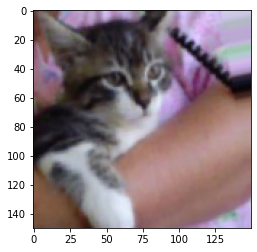

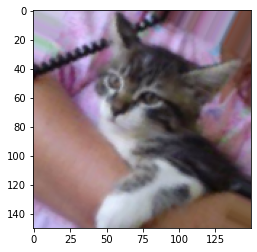

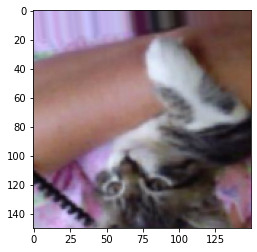

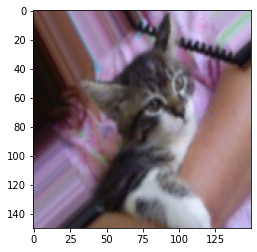

In [4]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

train_cats_dir = train_dir = os.path.join('datasets', 'dogs_and_cats_small', 'train', 'cats')
fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 테스트 이미지 선택
img_path = fnames[77]

# 이미지 읽고 크기 변경
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 배열 변환
x = image.img_to_array(img)

# (1, 150, 150, 3) 변환
x = x.reshape((1,) + x.shape)

# 랜덤하게 변환된 이미지 배치 생성
i = 0

for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

# II. Data Preprocessing

> ## 1) Image_File Directory Setting

* train_dir
* valid_dir
* test_dir

In [5]:
train_dir = './datasets/dogs_and_cats_small/train'
valid_dir = './datasets/dogs_and_cats_small/validation'
test_dir = './datasets/dogs_and_cats_small/test'

> ## 2) ImageDataGenerator( ) & flow_from_directory( )

* Normalization & Augmentation
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_directory( )

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# With Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

# Without Augmentation 
valid_datagen = ImageDataGenerator(rescale = 1./255)



# With Augmentation
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

# Without Augmentation
valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# III. CNN Keras Modeling

> ## 1) Model Define

* Feature Extraction & Classification
 * Dropout Layer

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

> ## 2) Model Compile

* 모델 학습방법 설정

In [9]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 30분
 * epochs : 60 -> 100

In [10]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 200,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/200
100/100 [==============================] - 15s 126ms/step - loss: 0.6959 - accuracy: 0.5055 - val_loss: 0.6926 - val_accuracy: 0.5410
Epoch 2/200
100/100 [==============================] - 12s 124ms/step - loss: 0.6938 - accuracy: 0.5130 - val_loss: 0.6892 - val_accuracy: 0.5230
Epoch 3/200
100/100 [==============================] - 12s 124ms/step - loss: 0.6778 - accuracy: 0.5615 - val_loss: 0.6757 - val_accuracy: 0.5720
Epoch 4/200
100/100 [==============================] - 12s 122ms/step - loss: 0.6819 - accuracy: 0.5530 - val_loss: 0.6906 - val_accuracy: 0.5160
Epoch 5/200
100/100 [==============================] - 12s 121ms/step - loss: 0.6760 - accuracy: 0.5635 - val_loss: 0.6675 - val_accuracy: 0.5810
Epoch 6/200
100/100 [==============================] - 12s 121ms/step - loss: 0.6640 - accuracy: 0.5835 - val_loss: 0.6675 - val_accuracy: 0.5820
Epoch 7/200
100/100 [==============================] - 12s 123ms/step - loss: 0.6655 - accuracy: 0.5660 - val_loss: 0.6869 -

Epoch 57/200
100/100 [==============================] - 12s 124ms/step - loss: 0.5010 - accuracy: 0.7535 - val_loss: 0.5431 - val_accuracy: 0.7200
Epoch 58/200
100/100 [==============================] - 12s 123ms/step - loss: 0.5125 - accuracy: 0.7555 - val_loss: 0.5354 - val_accuracy: 0.7420
Epoch 59/200
100/100 [==============================] - 12s 122ms/step - loss: 0.5023 - accuracy: 0.7535 - val_loss: 0.5610 - val_accuracy: 0.7160
Epoch 60/200
100/100 [==============================] - 12s 121ms/step - loss: 0.5127 - accuracy: 0.7435 - val_loss: 0.5449 - val_accuracy: 0.7280
Epoch 61/200
100/100 [==============================] - 13s 126ms/step - loss: 0.5118 - accuracy: 0.7445 - val_loss: 0.5202 - val_accuracy: 0.7340
Epoch 62/200
100/100 [==============================] - 13s 126ms/step - loss: 0.5066 - accuracy: 0.7535 - val_loss: 0.5209 - val_accuracy: 0.7470
Epoch 63/200
100/100 [==============================] - 12s 123ms/step - loss: 0.4981 - accuracy: 0.7545 - val_loss: 0

100/100 [==============================] - 12s 122ms/step - loss: 0.4106 - accuracy: 0.8105 - val_loss: 0.5814 - val_accuracy: 0.7290
Epoch 113/200
100/100 [==============================] - 12s 122ms/step - loss: 0.3946 - accuracy: 0.8230 - val_loss: 0.4823 - val_accuracy: 0.7900
Epoch 114/200
100/100 [==============================] - 12s 122ms/step - loss: 0.4022 - accuracy: 0.8220 - val_loss: 0.5692 - val_accuracy: 0.7360
Epoch 115/200
100/100 [==============================] - 12s 122ms/step - loss: 0.3788 - accuracy: 0.8345 - val_loss: 0.5190 - val_accuracy: 0.7750
Epoch 116/200
100/100 [==============================] - 12s 122ms/step - loss: 0.3936 - accuracy: 0.8205 - val_loss: 0.4902 - val_accuracy: 0.7760
Epoch 117/200
100/100 [==============================] - 12s 122ms/step - loss: 0.3649 - accuracy: 0.8365 - val_loss: 0.4907 - val_accuracy: 0.7840
Epoch 118/200
100/100 [==============================] - 12s 122ms/step - loss: 0.3928 - accuracy: 0.8260 - val_loss: 0.5226 -

100/100 [==============================] - 12s 123ms/step - loss: 0.3288 - accuracy: 0.8530 - val_loss: 0.5613 - val_accuracy: 0.7580
Epoch 168/200
100/100 [==============================] - 12s 123ms/step - loss: 0.3220 - accuracy: 0.8615 - val_loss: 0.4813 - val_accuracy: 0.7740
Epoch 169/200
100/100 [==============================] - 12s 123ms/step - loss: 0.3047 - accuracy: 0.8615 - val_loss: 0.4796 - val_accuracy: 0.8030
Epoch 170/200
100/100 [==============================] - 12s 123ms/step - loss: 0.3178 - accuracy: 0.8625 - val_loss: 0.4640 - val_accuracy: 0.8140
Epoch 171/200
100/100 [==============================] - 12s 124ms/step - loss: 0.3182 - accuracy: 0.8650 - val_loss: 0.5218 - val_accuracy: 0.7900
Epoch 172/200
100/100 [==============================] - 12s 122ms/step - loss: 0.3062 - accuracy: 0.8735 - val_loss: 0.5208 - val_accuracy: 0.7910
Epoch 173/200
100/100 [==============================] - 12s 122ms/step - loss: 0.3041 - accuracy: 0.8685 - val_loss: 0.5130 -

> ## 4) 학습 결과 시각화

* Loss Visualization

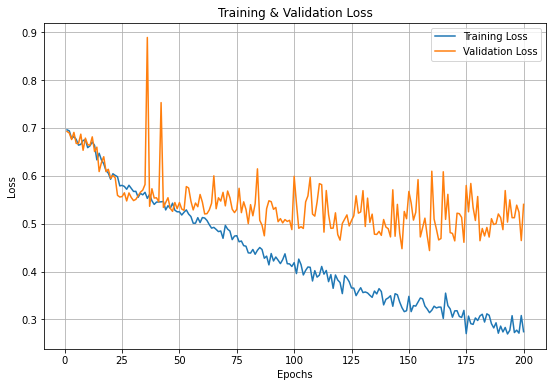

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

* Accuracy Visualization

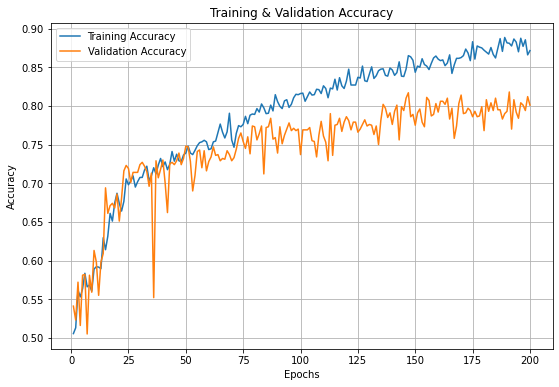

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate

* test_generator

In [13]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


* Loss & Accuracy

In [14]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 2s 38ms/step - loss: 0.6065 - accuracy: 0.7940
Loss = 0.60649
Accuracy = 0.79400


# IV. Model Save

> ## Model Save

In [15]:
model.save('./models/003_dogs_and_cats_augmentation.h5')

In [16]:
%cd models/
!dir

C:\Users\master\TIL\Big Data Analysis\Deep Learning\models
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: BA07-2AEC

 C:\Users\master\TIL\Big Data Analysis\Deep Learning\models 디렉터리

2021-08-07  오전 11:12    <DIR>          .
2021-08-07  오전 11:12    <DIR>          ..
2021-08-06  오후 05:19        41,498,896 002_dogs_and_cats_small.h5
2021-08-07  오후 08:30        41,499,544 003_dogs_and_cats_augmentation.h5
2021-08-07  오전 11:12       140,748,016 005_dogs_and_cats_fine_tuning.h5
               3개 파일         223,746,456 바이트
               2개 디렉터리  66,855,989,248 바이트 남음


> ## Model Load

In [17]:
%cd ../

C:\Users\master\TIL\Big Data Analysis\Deep Learning


In [18]:
from tensorflow.keras.models import load_model

model_google = load_model('./models/003_dogs_and_cats_augmentation.h5')

In [19]:
loss, accuracy = model_google.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 2s 38ms/step - loss: 0.6065 - accuracy: 0.7940
Loss = 0.60649
Accuracy = 0.79400
